Unique classes in the dataset: [0, 1, 2, 3, 4]


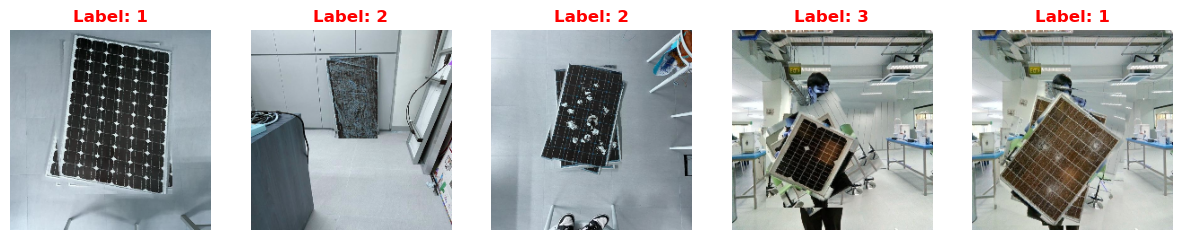

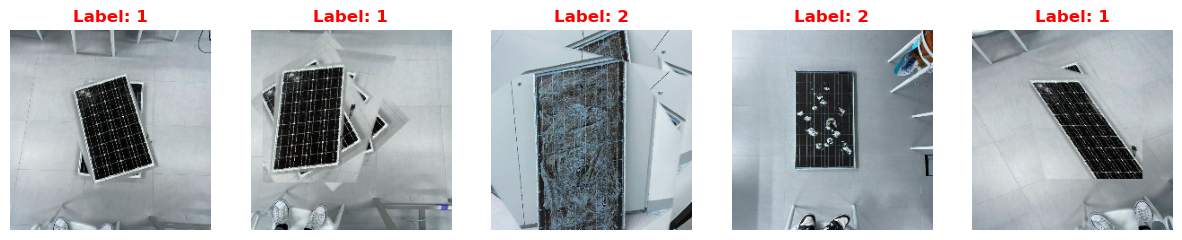

error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


NameError: name 'dataset' is not defined

TypeError: cannot unpack non-iterable numpy.int64 object

<Figure size 2000x1000 with 0 Axes>

FileNotFoundError: [Errno 2] No such file or directory: 'retinanet/train/_annotations.csv'

2024-04-26 20:24:07.985271: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-04-26 20:24:07.985316: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: PICL
2024-04-26 20:24:07.985323: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: PICL
2024-04-26 20:24:07.985500: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 535.171.4
2024-04-26 20:24:07.985524: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 535.161.7
2024-04-26 20:24:07.985531: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:251] kernel version 535.161.7 does not match DSO version 535.171.4 -- cannot find working devices in this configuration


Epoch 1/10


/home/mahin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 47s 878ms/step - accuracy: 0.3614 - loss: 1.4438 - val_accuracy: 0.1585 - val_loss: 1.4217
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 876ms/step - accuracy: 0.3550 - loss: 1.2885 - val_accuracy: 0.1585 - val_loss: 1.4261
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 861ms/step - accuracy: 0.3616 - loss: 1.2611 - val_accuracy: 0.1585 - val_loss: 1.4470
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 859ms/step - accuracy: 0.3546 - loss: 1.2454 - val_accuracy: 0.1585 - val_loss: 1.4559
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 863ms/step - accuracy: 0.3811 - loss: 1.2518 - val_accuracy: 0.1585 - val_loss: 1.4503
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 876ms/step - accuracy: 0.3577 - loss: 1.2673 - val_accuracy: 0.1585 - val_loss: 1.4730
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 43s 861ms/step - accuracy: 0.4050 - loss: 1.1967 - val_accuracy: 0.1585 - val_loss: 1.4541
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 873ms/step - accuracy: 0.4005 - loss: 1.2368 - val_accuracy: 0.158

In [24]:
import os
import cv2
import xml.etree.ElementTree as ET
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Base directory of the VOC dataset
base_dir = '/home/mahin/Downloads/Solar Panel Fault Detection Pascal VOC XML'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'valid')

# Function to parse the XML file and get the annotation data
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    boxes = []
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        xmlbox = obj.find('bndbox')
        bndbox = (int(xmlbox.find('xmin').text),
                  int(xmlbox.find('ymin').text),
                  int(xmlbox.find('xmax').text),
                  int(xmlbox.find('ymax').text))
        boxes.append((bndbox, class_name))
    return boxes


# Function to load dataset (images and labels)
def load_dataset(directory):
    images = []
    labels = []
    for img_filename in os.listdir(directory):
        if img_filename.endswith('.jpg'):
            img_path = os.path.join(directory, img_filename)
            annotation_path = img_path.replace('.jpg', '.xml')
            boxes = parse_annotation(annotation_path)

            image = cv2.imread(img_path)
            image = cv2.resize(image, (224, 224))
            images.append(image)

            # Assuming single object classification
            labels.append(boxes[0][1])  # Taking the first object's class label in the image
            
    return np.array(images), labels

# Load all datasets
train_images, train_labels = load_dataset(train_dir)
test_images, test_labels = load_dataset(test_dir)
val_images, val_labels = load_dataset(val_dir)

# Store label names for later use (do this before transforming labels to one-hot)
test_label_names = np.array(test_labels)  # Copy original label names

# Convert labels to numerical values
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)
val_labels = label_encoder.transform(val_labels)

# Convert to one-hot encoding
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
val_labels = to_categorical(val_labels)

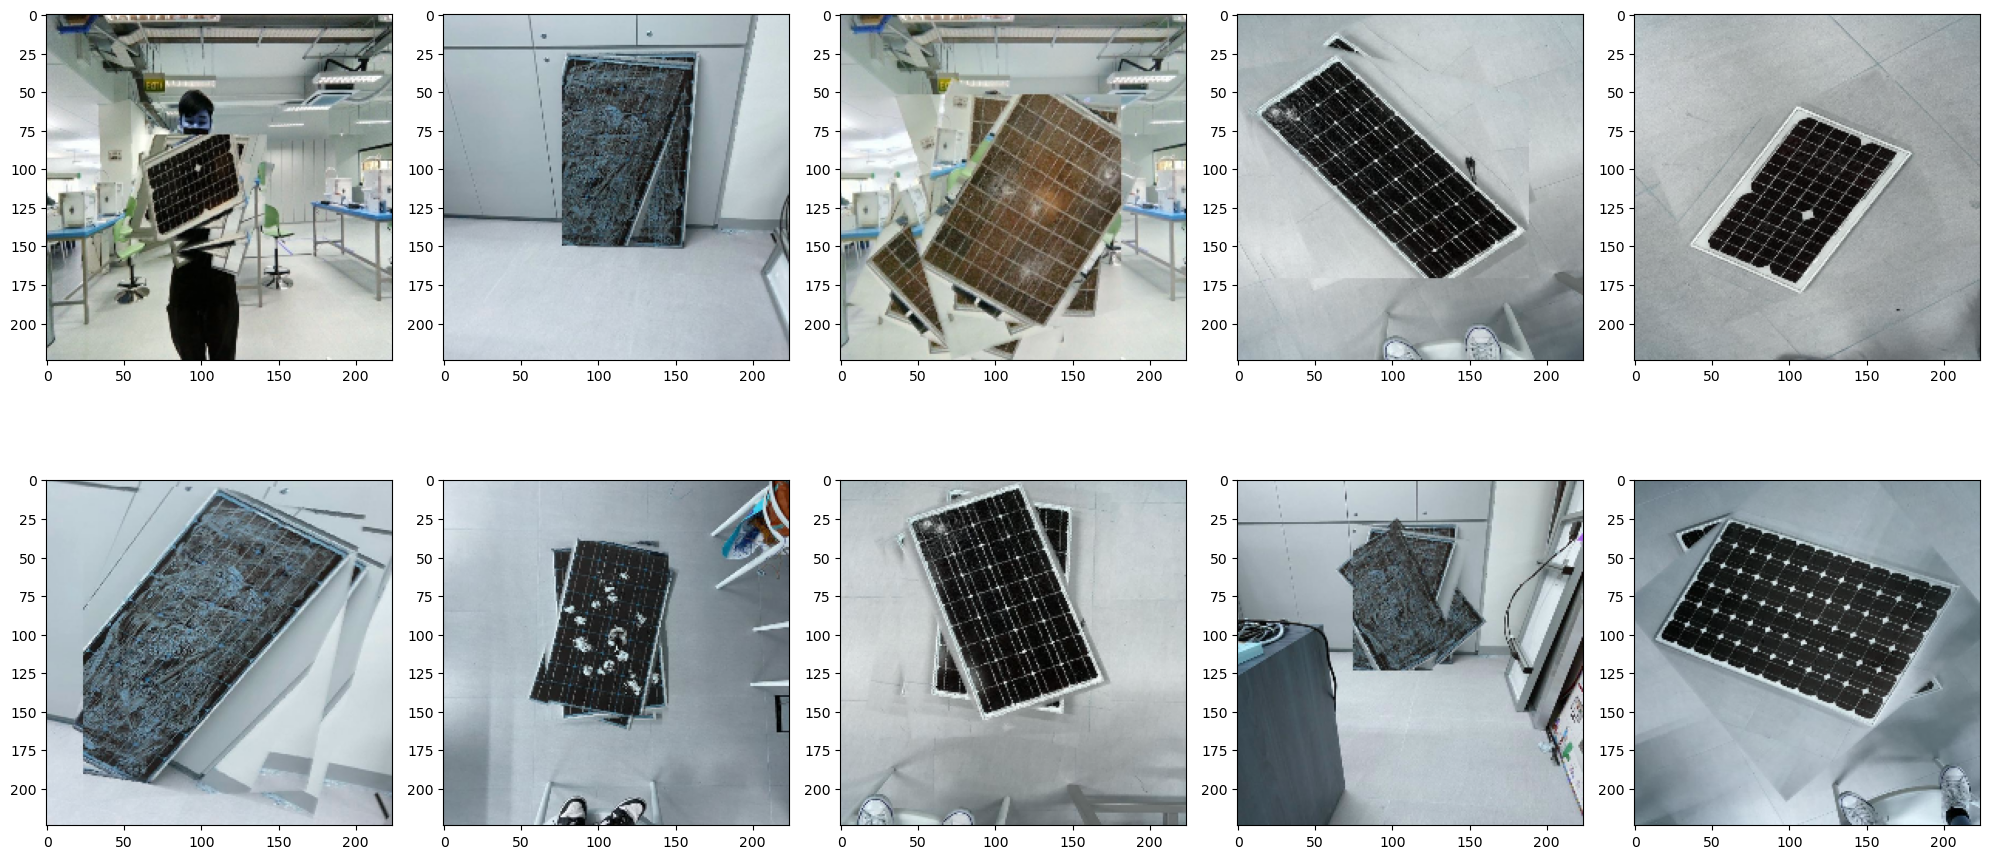

In [25]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Make sure you've run the dataset loading code before this

# Select 10 random indices
sample_indices = random.sample(range(len(train_images)), 10)

# Set up the matplotlib figure and axes
plt.figure(figsize=(20, 10))

for i, index in enumerate(sample_indices):
    # Load the image
    image = train_images[index]
    # Load the annotations
    annotations = train_labels[index]  # Assuming annotations are in the format (xmin, ymin, xmax, ymax, class_name)

    # Add subplot
    plt.subplot(2, 5, i+1)
    plt.imshow(image)

    

plt.tight_layout()
plt.show()


In [ ]:

from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the VGG16 model
for layer in base_model.layers:
    layer.trainable = False

# Add new custom layers on top of VGG16
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output_layer = Dense(train_labels.shape[1], activation='softmax')(x)  # train_labels.shape[1] gives the number of classes

# Define the new model
model = Model(inputs=base_model.input, outputs=output_layer)

learning_rate = 0.0001

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Assuming that your data is already loaded and preprocessed
train_generator = train_datagen.flow(train_images, train_labels, batch_size=32)
val_generator = val_datagen.flow(val_images, val_labels, batch_size=32)


# Fit the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=32)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test loss: {test_loss}, test accuracy: {test_accuracy}')

Epoch 1/10


/home/mahin/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 18s 627ms/step - accuracy: 0.5825 - loss: 1.0524 - val_accuracy: 0.8415 - val_loss: 0.5773
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 603ms/step - accuracy: 0.8427 - loss: 0.4712 - val_accuracy: 0.8902 - val_loss: 0.3519
Epoch 3/10
 5/25 ━━━━━━━━━━━━━━━━━━━━ 10s 540ms/step - accuracy: 0.9298 - loss: 0.2555

In [ ]:
# Plot the training and validation accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation accuracy
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss using a logarithmic scale
plt.plot(range(1, len(train_loss) + 1), np.log(train_loss), label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), np.log(val_loss), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss (Log Scale)')
plt.legend()
plt.show()

# Save the accuracy plot as an image
plt.savefig('accuracy_plot.png', bbox_inches='tight')

# Calculate and display the best validation accuracy and loss
best_val_accuracy = max(val_accuracy)
best_val_loss = min(val_loss)
print(f'Best Validation Accuracy: {best_val_accuracy:.4f}')
print(f'Best Validation Loss: {best_val_loss:.4f}')

In [ ]:
# Get the true labels for the test data
true_labels = test_label_names

print(test_label_names)

# Get the predictions for the test data
predictions = model.predict(test_generator)
predicted_labels_encoded = np.argmax(predictions, axis=1)

# Convert encoded labels back to original names
predicted_labels = label_encoder.inverse_transform(predicted_labels_encoded)

print(predicted_labels)

# Since test_label_names are the true labels in their original form, use them directly
print("Classification Report:")
print(classification_report(test_label_names, predicted_labels, target_names=label_encoder.classes_))

# Calculate and plot confusion matrix
cm = confusion_matrix(test_label_names, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()


In [ ]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

# Get the true labels for the test data
true_labels = train_labels.shape[1]

print(true_labels)
print(train_labels)

# Get the predictions for the test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate and print classification report
class_names = list(train_labels.class_indices.keys())
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# Calculate and plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create an annotation array with the same shape as your confusion matrix
annot_array = np.array([['0' if item == 0 else str(item) for item in row] for row in cm])

# Create the confusion matrix plot manually
fig, ax = plt.subplots(figsize=(10, 8))

# Set the colormap
cmap = plt.cm.Blues

# Normalize the confusion matrix data
normed_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# This is the colormap I'd like to use.
cmap = sns.color_palette("Blues", as_cmap=True)

# Plot the heatmap
ax.imshow(normed_cm, interpolation='nearest', cmap=cmap)

# Add the color bar
cbar = ax.figure.colorbar(ax.imshow(normed_cm, interpolation='nearest', cmap=cmap), ax=ax)
cbar.ax.set_ylabel('Relative Frequency', rotation=-90, va="bottom")

# Add the text annotations.
thresh = normed_cm.max() / 1.5
for i in range(normed_cm.shape[0]):
    for j in range(normed_cm.shape[1]):
        ax.text(j, i, annot_array[i, j],
                ha="center", va="center",
                color="white" if normed_cm[i, j] > thresh else "black")

# Set the ticks and labels.
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Set labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Custom Confusion Matrix')

# Show the plot
plt.show()



# Get the true and predicted class distributions
true_class_distribution = np.bincount(true_labels, minlength=num_classes)
predicted_class_distribution = np.bincount(predicted_labels, minlength=num_classes)

print("True class distribution:")
print(dict(zip(class_names, true_class_distribution)))

print("Predicted class distribution:")
print(dict(zip(class_names, predicted_class_distribution)))

